##**IMPORTANDO AS BIBLIOTECAS/MÓDULOS**

* gcsfs -> conexão com o GCP
* pymongo -> Conexão com o MongoDB
* pandas -> manipulação e análise de dados
* pyspark -> framework para processar grandes quantidades de dados
* fsspec -> projeto para fornecer uma interface Python unificada para sistemas de arquivos locais, remotos e incorporados e armazenamento de bytes.
* pandera -> validação de schema

In [22]:
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install pymongo 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
pip install fsspec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
pip install pandera

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* psycopg2 -> Adaptador Postgres
* requests -> Solicitações HTTP em Python
* pymongo -> Conexão com o MongoDB
* sqlalchemy -> Mapeamento Objeto Relacional
* datetime -> fornece as classes para manipulação de datas e horas
* csv -> ler e gravar arquivos .csv
* collections -> trabalhar com dados de maneira eficiente
* numpy -> processamento de grandes, multi-dimensionais arranjos e matrizes, juntamente com uma grande coleção de funções matemáticas de alto nível para operar sobre estas matrizes
* pandera -> validação do schema

In [28]:
import psycopg2
import requests
import pymongo
import sqlalchemy
import datetime
import csv
import collections
import numpy as np
import pandera as pa

* Pandas -> análise e manipulação de dados
* os -> automação de processos em Python
* storage -> armazenamento em nuvem

In [29]:
import pandas as pd
import pyspark.sql.functions as F
from google.cloud import storage

In [30]:
import os

In [31]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import isnull, isnan, when, count, col
from pyspark.sql.functions import *
from pyspark.sql.functions import ceil, col

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**CONEXÃO GCP**

INCLUINDO A CHAVE DE SEGURANÇA DO GCP

In [33]:
serviceAccount = '/content/drive/MyDrive/projeto-final-the-last-dance-8b51b88868a6.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

ACESSANDO O BUCKET

In [34]:
acesso = storage.Client()

bucket = acesso.get_bucket('projeto-final')

CRIANDO O DATAFRAME

In [35]:
bucket.blob('Mortalidade_Geral_2019.csv')

<Blob: projeto-final, Mortalidade_Geral_2019.csv, None>

In [36]:
path = 'gs://projeto-final/arq-original/Mortalidade_Geral_2019.csv'

CONVERTENDO ARQUIVO CID -> JSON EM CSV

In [37]:
df_cid = pd.read_json('gs://projeto-final/arq-original/cid10.json')

In [38]:
df_cid.codigo=df_cid.codigo.str.replace('.','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [39]:
df_cid.to_csv('gs://projeto-final/arq-original/cid10.csv', index=False)

##**NORMALIZAÇÃO E TRATAMENTO COM PYSPARK**

CONEXÃO COM A SPARKSESSION

In [40]:
spark = ( SparkSession.builder
                        .master("local")
                        .appName("projeto-final")
                        .config("spark.ui.port", "4050")
                        .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar')
                        .getOrCreate() 
        )

In [41]:
spark_2019 = ( spark.read.format('csv')
                       .option('header', 'true')
                       .option('inferschema', 'true')
                       .option('delimiter', ';')
                       .load('gs://projeto-final/arq-original/Mortalidade_Geral_2019.csv')
)

In [42]:
df_cid1 = ( spark.read.format("csv")
                  .option("header", "true")
                  .option("inferschema", "true")
                  .option("delimiter", ",")
                  .load('gs://projeto-final/arq-original/cid10.csv')
)

In [43]:
df_uf1 = ( spark.read.format("csv")
                  .option("header", "true")
                  .option("inferschema", "true")
                  .option("delimiter", ",")
                  .load('gs://projeto-final/arq-original/Arquivos auxiliares/UF-Munic.csv')
)

PRÉ-ANALISE DOS DADOS -> DF SPARK_2019

In [44]:
spark_2019.count()

1349801

In [45]:
spark_2019.dtypes

[('ORIGEM', 'int'),
 ('TIPOBITO', 'int'),
 ('DTOBITO', 'int'),
 ('HORAOBITO', 'int'),
 ('NATURAL', 'int'),
 ('CODMUNNATU', 'int'),
 ('DTNASC', 'int'),
 ('IDADE', 'int'),
 ('SEXO', 'int'),
 ('RACACOR', 'int'),
 ('ESTCIV', 'int'),
 ('ESC', 'int'),
 ('ESC2010', 'int'),
 ('SERIESCFAL', 'int'),
 ('OCUP', 'int'),
 ('CODMUNRES', 'int'),
 ('LOCOCOR', 'int'),
 ('CODESTAB', 'int'),
 ('ESTABDESCR', 'string'),
 ('CODMUNOCOR', 'int'),
 ('IDADEMAE', 'int'),
 ('ESCMAE', 'int'),
 ('ESCMAE2010', 'int'),
 ('SERIESCMAE', 'int'),
 ('OCUPMAE', 'int'),
 ('QTDFILVIVO', 'int'),
 ('QTDFILMORT', 'int'),
 ('GRAVIDEZ', 'int'),
 ('SEMAGESTAC', 'int'),
 ('GESTACAO', 'int'),
 ('PARTO', 'int'),
 ('OBITOPARTO', 'int'),
 ('PESO', 'int'),
 ('TPMORTEOCO', 'int'),
 ('OBITOGRAV', 'int'),
 ('OBITOPUERP', 'int'),
 ('ASSISTMED', 'int'),
 ('EXAME', 'int'),
 ('CIRURGIA', 'int'),
 ('NECROPSIA', 'int'),
 ('LINHAA', 'string'),
 ('LINHAB', 'string'),
 ('LINHAC', 'string'),
 ('LINHAD', 'string'),
 ('LINHAII', 'string'),
 ('CAUSABAS'

In [46]:
spark_2019.show(1)

+------+--------+--------+---------+-------+----------+--------+-----+----+-------+------+---+-------+----------+------+---------+-------+--------+----------+----------+--------+------+----------+----------+-------+----------+----------+--------+----------+--------+-----+----------+----+----------+---------+----------+---------+-----+--------+---------+------+------+------+------+-------+--------+------+----------+----------+---------+--------+-----+----------+-----+----------+----------+----------+---------+----------+----------+----------+---------+--------+---------+-----------------+----------+--------+----------+----------+----------+--------+-------+----------+----------+--------+----------+--------+------+----------+----------+---------+--------+----------+---------+---------+--------+--------+
|ORIGEM|TIPOBITO| DTOBITO|HORAOBITO|NATURAL|CODMUNNATU|  DTNASC|IDADE|SEXO|RACACOR|ESTCIV|ESC|ESC2010|SERIESCFAL|  OCUP|CODMUNRES|LOCOCOR|CODESTAB|ESTABDESCR|CODMUNOCOR|IDADEMAE|ESCMAE|ES

In [47]:
#CONTANDO OS CAMPOS "NULL" DE CADA COLUNA DO DF
spark_2019.select([count(when(isnull(c), c)).alias(c) for c in spark_2019.columns]).show()

+------+--------+-------+---------+-------+----------+------+-----+----+-------+------+------+-------+----------+------+---------+-------+--------+----------+----------+--------+-------+----------+----------+-------+----------+----------+--------+----------+--------+-------+----------+-------+----------+---------+----------+---------+-------+--------+---------+------+------+------+-------+-------+--------+-------+----------+----------+---------+--------+-------+----------+------+----------+----------+----------+---------+----------+----------+----------+---------+--------+---------+--------+----------+--------+----------+----------+----------+--------+-------+----------+----------+--------+----------+--------+-------+----------+----------+---------+--------+----------+---------+---------+--------+--------+
|ORIGEM|TIPOBITO|DTOBITO|HORAOBITO|NATURAL|CODMUNNATU|DTNASC|IDADE|SEXO|RACACOR|ESTCIV|   ESC|ESC2010|SERIESCFAL|  OCUP|CODMUNRES|LOCOCOR|CODESTAB|ESTABDESCR|CODMUNOCOR|IDADEMAE| ESC

DROPANDO COLUNAS QUE NÃO SERÃO UTILIZADAS

In [48]:
spark_2019 = spark_2019.drop(*('ORIGEM','HORAOBITO','ESTCIV','ESC','ESC2010','SERIESCFAL','CODMUNRES','IDADEMAE','ESCMAE','ESCMAE2010','SERIESCMAE','OCUPMAE','QTDFILMORT','GRAVIDEZ','SEMAGESTAC','GESTACAO','PARTO','OBITOPARTO','PESO','TPMORTEOCO','ASSISTMED','EXAME','CIRURGIA','NECROPSIA','CB_PRE','COMUNSVOIM','DTATESTADO','ACIDTRAB','NUMEROLOTE','DTINVESTIG','DTCADASTRO','ATESTANTE','STCODIFICA','CODIFICADO','VERSAOSIST','VERSAOSCB','FONTEINV','DTRECEBIM','ATESTADO','DTRECORIGA','CAUSAMAT','ESCMAEAGR1','ESCFALAGR1','DTCADINV','DTCONINV','FONTES','TPRESGINFO','TPNIVELINV','DTCADINF','MORTEPARTO','DTCONCASO','ALTCAUSA','TPPOS','TP_ALTERA','CB_ALT','CIRCOBITO','FONTE','NUDIASOBCO','TPOBITOCOR','QTDFILVIVO','OBITOGRAV','OBITOPUERP','LINHAA','LINHAB','LINHAC','LINHAD','LINHAII','IDADE','NUDIASOBIN', 'NUDIASINF', 'FONTESINF','ESTABDESCR','NATURAL','CODMUNNATU','DIFDATA','CONTADOR'))

In [49]:
spark_2019.show(5)

+--------+--------+--------+----+-------+------+-------+--------+----------+--------+----------+----------+--------+
|TIPOBITO| DTOBITO|  DTNASC|SEXO|RACACOR|  OCUP|LOCOCOR|CODESTAB|CODMUNOCOR|CAUSABAS|CAUSABAS_O|STDOEPIDEM|STDONOVA|
+--------+--------+--------+----+-------+------+-------+--------+----------+--------+----------+----------+--------+
|       2|21012019|18021961|   1|      2|512105|      1| 2388685|    290750|    I120|      I120|         0|       1|
|       2|28012019| 3071938|   2|   null|999992|      1| 2388685|    290750|    A419|      A419|         0|       1|
|       2|27012019|15111945|   2|      4|999992|      1| 2388685|    290750|    E039|      E039|         0|       1|
|       2|12012019| 4111971|   1|      4|  null|      1| 2388685|    290750|    R220|      R220|         0|       1|
|       2|10012019|12101946|   2|      4|999992|      1| 2388685|    290750|    C159|      C159|         0|       1|
+--------+--------+--------+----+-------+------+-------+--------

COMANDO PARA RENOMEAR COLUNAS

In [50]:
spark_2019 = spark_2019.withColumnRenamed("contador", "SEQUENCIA").withColumnRenamed("TIPOBITO", "TIPO_OBITO").withColumnRenamed("DTOBITO", "DATA_OBITO").withColumnRenamed("RACACOR", "RACA_COR").withColumnRenamed("OCUP", "OCUPACAO").withColumnRenamed("LOCOCOR", "LOCAL_OCORRENCIA").withColumnRenamed("CODESTAB", "COD_ESTABELECIMENTO").withColumnRenamed("CODMUNOCOR", "CIDADE_OBITO").withColumnRenamed("CAUSABAS", "CAUSA_OBITO").withColumnRenamed("STDOEPIDEM", "STATUS_D_OEPIDEM").withColumnRenamed("STDONOVA", "STATUS_D_O_NOVA")

In [51]:
df_cid1 = df_cid1.withColumnRenamed("codigo","CAUSA_OBITO")

In [52]:
spark_2019.show(5)

+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSA_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|
+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|         2|  21012019|18021961|   1|       2|  512105|               1|            2388685|      290750|       I120|      I120|               0|              1|
|         2|  28012019| 3071938|   2|    null|  999992|               1|            2388685|      290750|       A419|      A419|               0|              1|
|         2|  27012019|15111945|   2|       4|  999992|               1|            2388685|      290750|       E039|      E039|               0|              1|
|         2|  12012019| 4111

In [53]:
#CONTANDO OS CAMPOS "NULL" DE CADA COLUNA DO DF
spark_2019.select([count(when(isnull(c), c)).alias(c) for c in spark_2019.columns]).show()

+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|TIPO_OBITO|DATA_OBITO|DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSA_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|
+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+
|         0|         0|  3791|   0|   34453|  213479|               0|             358733|           0|          0|       887|               1|              0|
+----------+----------+------+----+--------+--------+----------------+-------------------+------------+-----------+----------+----------------+---------------+



In [54]:
#JOIN DE DATAFRAMES
df_inner_2019 = spark_2019.join(df_cid1, on=['CAUSA_OBITO'], how='left')

In [55]:
#RENOMEANDO COLUNA RECEM CRIADA
df_inner_2019 = df_inner_2019.withColumnRenamed("nome","DESCRICAO_OBITO")

In [56]:
#VERIFICANDO QUANTAS COLUNAS TEM O DF
print(len(df_inner_2019.columns))

14


In [57]:
#CRIAÇÃO DE COLUNA PARA CONTAGEM DOS OBITOS
df_inner_2019 = df_inner_2019.withColumn('QTD_OBITO',F.lit(1))

In [58]:
#FAZENDO BACKUP DO DF
df2019 = df_inner_2019

In [59]:
df2019.show(5)

+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|       I120|         2|  21012019|18021961|   1|       2|  512105|               1|            2388685|      290750|      I120|               0|              1|Doença Renal Hipe...|        1|
|       A419|         2|  28012019| 3071938|   2|    null|  999992|               1|            2388685|      290750|      A419|               0|              1|Septicemia Não Es...|        1|
|       E039|         2|  27012019|

REALIZANDO O TRATAMENTO DAS DATAS

In [60]:
df2019 = df2019.withColumn('DATA_OBITO', lpad(df2019.DATA_OBITO,8, '0')).withColumn('DTNASC', lpad(df2019.DTNASC,8, '0'))

In [61]:
df2019.show(5)

+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|  DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+--------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|       I120|         2|  21012019|18021961|   1|       2|  512105|               1|            2388685|      290750|      I120|               0|              1|Doença Renal Hipe...|        1|
|       A419|         2|  28012019|03071938|   2|    null|  999992|               1|            2388685|      290750|      A419|               0|              1|Septicemia Não Es...|        1|
|       E039|         2|  27012019|

In [62]:
df2019 = df2019.withColumn("DATA_OBITO", F.to_date(F.col("DATA_OBITO").cast("string"), 'ddMMyyyy')).withColumn("DTNASC", F.to_date(F.col("DTNASC").cast("string"), 'ddMMyyyy'))

In [63]:
df2019.show(5)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+
|       I120|         2|2019-01-21|1961-02-18|   1|       2|  512105|               1|            2388685|      290750|      I120|               0|              1|Doença Renal Hipe...|        1|
|       A419|         2|2019-01-28|1938-07-03|   2|    null|  999992|               1|            2388685|      290750|      A419|               0|              1|Septicemia Não Es...|        1|
|       E039|         2|2

CALCULANDO A IDADE EM QUE OCORRERAM OS OBITOS

In [64]:
#MONTHS_BETWEEN() - RETORNA A DIFERENÇA ENTRE DUAS DATAS EM MESES
from pyspark.sql.functions import *
df2019.select(F.col('DTNASC'), F.col('DATA_OBITO'), F.months_between(F.col('DATA_OBITO'), F.col('DTNASC')).alias('IDADE')).show()

+----------+----------+-------------+
|    DTNASC|DATA_OBITO|        IDADE|
+----------+----------+-------------+
|1961-02-18|2019-01-21| 695.09677419|
|1938-07-03|2019-01-28| 966.80645161|
|1945-11-15|2019-01-27| 878.38709677|
|1971-11-04|2019-01-12| 566.25806452|
|1946-10-12|2019-01-10| 866.93548387|
|1932-06-22|2019-01-24|1039.06451613|
|1951-12-11|2019-01-27| 805.51612903|
|1950-03-05|2019-01-27| 826.70967742|
|1943-07-14|2019-01-25| 906.35483871|
|1978-12-10|2019-01-25| 481.48387097|
|1993-12-11|2019-01-25|  301.4516129|
|1942-11-07|2019-01-25| 914.58064516|
|1995-04-03|2019-01-27| 285.77419355|
|1955-11-12|2019-01-28| 758.51612903|
|1920-08-22|2019-01-29|1181.22580645|
|1961-05-04|2019-01-30| 692.83870968|
|1937-03-29|2019-02-05| 982.22580645|
|1920-02-15|2019-01-25|1187.32258065|
|1926-10-18|2019-01-28|1107.32258065|
|1935-01-08|2019-01-31|1008.74193548|
+----------+----------+-------------+
only showing top 20 rows



In [65]:
df2019 = df2019.withColumn('IDADE', F.months_between(F.col('DATA_OBITO'), F.col('DTNASC')))

In [66]:
from pyspark.sql.functions import ceil, col
df2019 = df2019.select("*",ceil("IDADE"))

In [67]:
df2019 = df2019.withColumn('IDADE_COMPLETA',((col('CEIL(IDADE)') / 12)))

In [68]:
from pyspark.sql.functions import ceil, col
df2019 = df2019.select("*",ceil("IDADE_COMPLETA"))

In [69]:
df2019 = df2019.drop('IDADE')

In [70]:
df2019 = df2019.drop('CEIL(IDADE)')

In [71]:
df2019 = df2019.drop('IDADE_COMPLETA')

In [72]:
#COMANDO PARA RENOMEAR COLUNAS
df2019 = df2019.withColumnRenamed("CEIL(IDADE_COMPLETA)", "IDADE_OBITO")

In [73]:
df2019.show(5)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+
|       I120|         2|2019-01-21|1961-02-18|   1|       2|  512105|               1|            2388685|      290750|      I120|               0|              1|Doença Renal Hipe...|        1|         58|
|       A419|         2|2019-01-28|1938-07-03|   2|    null|  999992|               1|            2388685|      290750|      A419|               0|              1|Septicemi

INFORMANDO OS ESTADOS EM QUE OCORRERAM OS OBITOS

Estas informações foram obtidas no dataset uf1

In [74]:
df2019 = df2019.withColumn('ESTADO_DA_OCORRENCIA', F.when((F.col('CIDADE_OBITO') > 310000) & (F.col('CIDADE_OBITO') < 319999), F.lit('Minas Gerais'))
                                              .when((F.col('CIDADE_OBITO') > 110000) & (F.col('CIDADE_OBITO') < 119999), F.lit('Rondônia'))
                                              .when((F.col('CIDADE_OBITO') > 120000) & (F.col('CIDADE_OBITO') < 129999), F.lit('Acre'))
                                              .when((F.col('CIDADE_OBITO') > 130000) & (F.col('CIDADE_OBITO') < 139999), F.lit('Amazonia'))
                                              .when((F.col('CIDADE_OBITO') > 140000) & (F.col('CIDADE_OBITO') < 149999), F.lit('Roraiama'))
                                              .when((F.col('CIDADE_OBITO') > 150000) & (F.col('CIDADE_OBITO') < 159999), F.lit('Pará'))
                                              .when((F.col('CIDADE_OBITO') > 160000) & (F.col('CIDADE_OBITO') < 169999), F.lit('Amapá'))
                                              .when((F.col('CIDADE_OBITO') > 170000) & (F.col('CIDADE_OBITO') < 179999), F.lit('Tocantins'))
                                              .when((F.col('CIDADE_OBITO') > 210000) & (F.col('CIDADE_OBITO') < 219999), F.lit('Maranhão'))
                                              .when((F.col('CIDADE_OBITO') > 220000) & (F.col('CIDADE_OBITO') < 229999), F.lit('Piauí'))
                                              .when((F.col('CIDADE_OBITO') > 230000) & (F.col('CIDADE_OBITO') < 239999), F.lit('Ceará'))
                                              .when((F.col('CIDADE_OBITO') > 240000) & (F.col('CIDADE_OBITO') < 249999), F.lit('Rio Grande do Norte'))
                                              .when((F.col('CIDADE_OBITO') > 250000) & (F.col('CIDADE_OBITO') < 259999), F.lit('Paraíba'))
                                              .when((F.col('CIDADE_OBITO') > 260000) & (F.col('CIDADE_OBITO') < 269999), F.lit('Pernambuco'))
                                              .when((F.col('CIDADE_OBITO') > 270000) & (F.col('CIDADE_OBITO') < 279999), F.lit('Alagoas'))
                                              .when((F.col('CIDADE_OBITO') > 280000) & (F.col('CIDADE_OBITO') < 289999), F.lit('Sergipe'))
                                              .when((F.col('CIDADE_OBITO') > 290000) & (F.col('CIDADE_OBITO') < 299999), F.lit('Bahia'))
                                              .when((F.col('CIDADE_OBITO') > 320000) & (F.col('CIDADE_OBITO') < 329999), F.lit('Espirito Santo'))
                                              .when((F.col('CIDADE_OBITO') > 330000) & (F.col('CIDADE_OBITO') < 339999), F.lit('Rio de Janeiro'))
                                              .when((F.col('CIDADE_OBITO') > 350000) & (F.col('CIDADE_OBITO') < 359999), F.lit('São Paulo'))
                                              .when((F.col('CIDADE_OBITO') > 410000) & (F.col('CIDADE_OBITO') < 419999), F.lit('Paraná'))
                                              .when((F.col('CIDADE_OBITO') > 420000) & (F.col('CIDADE_OBITO') < 429999), F.lit('Santa Catarina'))
                                              .when((F.col('CIDADE_OBITO') > 430000) & (F.col('CIDADE_OBITO') < 439999), F.lit('Rio Grande do Sul'))
                                              .when((F.col('CIDADE_OBITO') > 500000) & (F.col('CIDADE_OBITO') < 509999), F.lit('Mato Grosso do Sul'))
                                              .when((F.col('CIDADE_OBITO') > 510000) & (F.col('CIDADE_OBITO') < 519999), F.lit('Mato Grosso'))
                                              .when((F.col('CIDADE_OBITO') > 520000) & (F.col('CIDADE_OBITO') < 529999), F.lit('Goiás'))
                                              .when((F.col('CIDADE_OBITO') > 530000) & (F.col('CIDADE_OBITO') < 539999), F.lit('DF'))
                                              .otherwise(F.lit('Não Informado')))               

In [75]:
df2019.show(10)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+--------------------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|CAUSABAS_O|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|ESTADO_DA_OCORRENCIA|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------+----------------+---------------+--------------------+---------+-----------+--------------------+
|       I120|         2|2019-01-21|1961-02-18|   1|       2|  512105|               1|            2388685|      290750|      I120|               0|              1|Doença Renal Hipe...|        1|         58|               Bahia|
|       A419|         2|2019-01-28|1938-07-03|   2|    null|  999992|               1|  

RENOMEANDO INFORMAÇÕES DAS COLUNAS RACA_COR, LOCAL_OCORRENCIA E SEXO

In [76]:
df2019 = df2019.withColumn('RACA_COR', F.regexp_replace('RACA_COR','1','Branca')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','2','Preta')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','3','Amarela')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','4','Parda')).withColumn('RACA_COR', F.regexp_replace('RACA_COR','5','Indigena'))

In [77]:
df2019 = df2019.withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','1','Hospital')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','2','Outros estabelecimentos de saúde')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','3','Domicílio')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','4','Via pública')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','5','Outros')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','6','Aldeia indígena')).withColumn('LOCAL_OCORRENCIA', F.regexp_replace('LOCAL_OCORRENCIA','9','Ignorado'))

In [78]:
df2019 = df2019.withColumn('SEXO', F.regexp_replace('SEXO','0','N/I')).withColumn('SEXO', F.regexp_replace('SEXO','1','Masc')).withColumn('SEXO', F.regexp_replace('SEXO','2','Fem'))

In [79]:
df2019 = df2019.drop('CAUSABAS_O')

In [80]:
df2019.show(5)

+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------------+---------------+--------------------+---------+-----------+--------------------+
|CAUSA_OBITO|TIPO_OBITO|DATA_OBITO|    DTNASC|SEXO|RACA_COR|OCUPACAO|LOCAL_OCORRENCIA|COD_ESTABELECIMENTO|CIDADE_OBITO|STATUS_D_OEPIDEM|STATUS_D_O_NOVA|     DESCRICAO_OBITO|QTD_OBITO|IDADE_OBITO|ESTADO_DA_OCORRENCIA|
+-----------+----------+----------+----------+----+--------+--------+----------------+-------------------+------------+----------------+---------------+--------------------+---------+-----------+--------------------+
|       I120|         2|2019-01-21|1961-02-18|Masc|   Preta|  512105|        Hospital|            2388685|      290750|               0|              1|Doença Renal Hipe...|        1|         58|               Bahia|
|       A419|         2|2019-01-28|1938-07-03| Fem|    null|  999992|        Hospital|            2388685|      290750|             

In [81]:
df2019.select('SEXO').distinct().collect()

[Row(SEXO='Fem'), Row(SEXO='N/I'), Row(SEXO='Masc')]

In [82]:
print(len(df2019.columns))

16


Inclusão de coluna por:
* Jovens - Indivíduos de até 19 anos;
* Adultos - Indivíduos com idade entre 20 até 59 anos;
* Idosos - Indivíduos de 60 anos em diante.

In [83]:
df2019 = (df2019.withColumn('IDADE', F.when((F.col('IDADE_OBITO') <= 19), F.lit('Jovem'))
                             .when((F.col('IDADE_OBITO') > 19) & (F.col('IDADE_OBITO') <= 59), F.lit('Adulto'))
                             .when((F.col('IDADE_OBITO') > 59), F.lit('Idoso')))
)

##**NORMALIZAÇÃO E TRATAMENTO COM PANDAS**

Convertendo df spark para pandas

In [84]:
df_pandas = df2019.toPandas()

In [85]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,I120,2,2019-01-21,1961-02-18,Masc,Preta,512105.0,Hospital,2388685.0,290750,0.0,1,Doença Renal Hipertensiva Com Insuficiência Renal,1,58.0,Bahia,Adulto


In [86]:
df_pandas.isnull().sum()

CAUSA_OBITO                  0
TIPO_OBITO                   0
DATA_OBITO                   0
DTNASC                    3791
SEXO                         0
RACA_COR                 34453
OCUPACAO                213479
LOCAL_OCORRENCIA             0
COD_ESTABELECIMENTO     358733
CIDADE_OBITO                 0
STATUS_D_OEPIDEM             1
STATUS_D_O_NOVA              0
DESCRICAO_OBITO              0
QTD_OBITO                    0
IDADE_OBITO               3791
ESTADO_DA_OCORRENCIA         0
IDADE                     3791
dtype: int64

SUBSTITUINDO OS CAMPOS NULL

In [87]:
df_pandas['DTNASC'].fillna(0, inplace=True)
df_pandas['RACA_COR'].fillna('Não Informado', inplace=True)
df_pandas['OCUPACAO'].fillna(0, inplace=True)
df_pandas['COD_ESTABELECIMENTO'].fillna(0, inplace=True)
df_pandas['STATUS_D_OEPIDEM'].fillna('Não Informado', inplace=True)
df_pandas['IDADE_OBITO'].fillna(0, inplace=True)

In [88]:
df_pandas.dtypes

CAUSA_OBITO              object
TIPO_OBITO                int32
DATA_OBITO               object
DTNASC                   object
SEXO                     object
RACA_COR                 object
OCUPACAO                float64
LOCAL_OCORRENCIA         object
COD_ESTABELECIMENTO     float64
CIDADE_OBITO              int32
STATUS_D_OEPIDEM         object
STATUS_D_O_NOVA           int32
DESCRICAO_OBITO          object
QTD_OBITO                 int32
IDADE_OBITO             float64
ESTADO_DA_OCORRENCIA     object
IDADE                    object
dtype: object

In [89]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,I120,2,2019-01-21,1961-02-18,Masc,Preta,512105.0,Hospital,2388685.0,290750,0.0,1,Doença Renal Hipertensiva Com Insuficiência Renal,1,58.0,Bahia,Adulto


CONSTRUÇÃO DO SCHEMA

In [90]:
schema = pa.DataFrameSchema(
    columns = {
        "CAUSA_OBITO":pa.Column(pa.String),
        "TIPO_OBITO":pa.Column(pa.Int32),
        "DATA_OBITO":pa.Column(pa.String),
        "DTNASC":pa.Column(pa.String),
        "SEXO":pa.Column(pa.String),
        "RACA_COR":pa.Column(pa.String),
        "OCUPACAO":pa.Column(pa.Float64),
        "LOCAL_OCORRENCIA":pa.Column(pa.String),
        "COD_ESTABELECIMENTO":pa.Column(pa.Float64),
        "CIDADE_OBITO":pa.Column(pa.Int32),
        "STATUS_D_OEPIDEM":pa.Column(pa.String),
        "STATUS_D_O_NOVA":pa.Column(pa.Int32),
        "DESCRICAO_OBITO":pa.Column(pa.String),
        "QTD_OBITO":pa.Column(pa.Int32),
        "IDADE_OBITO":pa.Column(pa.Float64),
        "ESTADO_DA_OCORRENCIA":pa.Column(pa.String)
            
          }
    
)

In [91]:
df_pandas.dtypes

CAUSA_OBITO              object
TIPO_OBITO                int32
DATA_OBITO               object
DTNASC                   object
SEXO                     object
RACA_COR                 object
OCUPACAO                float64
LOCAL_OCORRENCIA         object
COD_ESTABELECIMENTO     float64
CIDADE_OBITO              int32
STATUS_D_OEPIDEM         object
STATUS_D_O_NOVA           int32
DESCRICAO_OBITO          object
QTD_OBITO                 int32
IDADE_OBITO             float64
ESTADO_DA_OCORRENCIA     object
IDADE                    object
dtype: object

In [92]:
schema.validate(df_pandas)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,I120,2,2019-01-21,1961-02-18,Masc,Preta,512105.0,Hospital,2388685.0,290750,0.0,1,Doença Renal Hipertensiva Com Insuficiência Renal,1,58.0,Bahia,Adulto
1,A419,2,2019-01-28,1938-07-03,Fem,Não Informado,999992.0,Hospital,2388685.0,290750,0.0,1,Septicemia Não Especificada,1,81.0,Bahia,Idoso
2,E039,2,2019-01-27,1945-11-15,Fem,Parda,999992.0,Hospital,2388685.0,290750,0.0,1,Hipotireoidismo Não Especificado,1,74.0,Bahia,Idoso
3,R220,2,2019-01-12,1971-11-04,Masc,Parda,0.0,Hospital,2388685.0,290750,0.0,1,"Tumefação, Massa ou Tumoração Localizadas da C...",1,48.0,Bahia,Adulto
4,C159,2,2019-01-10,1946-10-12,Fem,Parda,999992.0,Hospital,2388685.0,290750,0.0,1,"Neoplasia Maligna do Esôfago, Não Especificado",1,73.0,Bahia,Idoso
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1349796,C539,2,2019-08-05,1988-02-02,Fem,Indigena,0.0,Aldeia indígena,0.0,130406,0.0,1,"Neoplasia Maligna do Colo do Útero, Não Especi...",1,32.0,Amazonia,Adulto
1349797,I219,2,2019-10-10,1920-12-25,Masc,Indigena,0.0,Aldeia indígena,0.0,120060,0.0,1,Infarto Agudo do Miocárdio Não Especificado,1,99.0,Acre,Idoso
1349798,C787,2,2019-05-31,1943-01-15,Fem,Indigena,0.0,Aldeia indígena,0.0,160050,0.0,1,Neoplasia Maligna Secundária do Fígado,1,77.0,Amapá,Idoso
1349799,I64,2,2019-08-31,1949-05-18,Masc,Indigena,0.0,Aldeia indígena,0.0,130406,0.0,1,"Acidente Vascular Cerebral, Não Especificado C...",1,71.0,Amazonia,Idoso


CONSTRUÇÃO DOS INSIGHTS PANDAS

In [93]:
df_pandas.head(1)

,CAUSA_OBITO,TIPO_OBITO,DATA_OBITO,DTNASC,SEXO,RACA_COR,OCUPACAO,LOCAL_OCORRENCIA,COD_ESTABELECIMENTO,CIDADE_OBITO,STATUS_D_OEPIDEM,STATUS_D_O_NOVA,DESCRICAO_OBITO,QTD_OBITO,IDADE_OBITO,ESTADO_DA_OCORRENCIA,IDADE
0,I120,2,2019-01-21,1961-02-18,Masc,Preta,512105.0,Hospital,2388685.0,290750,0.0,1,Doença Renal Hipertensiva Com Insuficiência Renal,1,58.0,Bahia,Adulto


In [94]:
df_pandas.groupby(['RACA_COR']).size().sort_values(ascending=False)

RACA_COR
Branca           686474
Parda            509936
Preta            107306
Não Informado     34453
Amarela            7359
Indigena           4273
dtype: int64

In [95]:
df_pandas.groupby(['SEXO']).size().sort_values(ascending=False)

SEXO
Masc    745519
Fem     603725
N/I        557
dtype: int64

In [96]:
df_pandas.groupby(['IDADE']).size().sort_values(ascending=False)

IDADE
Idoso     947669
Adulto    338213
Jovem      60128
dtype: int64

In [97]:
df_pandas.groupby(['IDADE','SEXO','RACA_COR','LOCAL_OCORRENCIA','DESCRICAO_OBITO']).size().sort_values(ascending=False).head(10)

IDADE   SEXO  RACA_COR  LOCAL_OCORRENCIA  DESCRICAO_OBITO                                                                              
Idoso   Fem   Branca    Hospital          Pneumonia Não Especificada                                                                       12222
        Masc  Branca    Hospital          Infarto Agudo do Miocárdio Não Especificado                                                      11146
                                          Pneumonia Não Especificada                                                                        9987
        Fem   Branca    Hospital          Infarto Agudo do Miocárdio Não Especificado                                                       9328
        Masc  Branca    Domicílio         Infarto Agudo do Miocárdio Não Especificado                                                       7394
        Fem   Branca    Hospital          Infecção do Trato Urinário de Localização Não Especificada                                       

##**GRAFICOS**

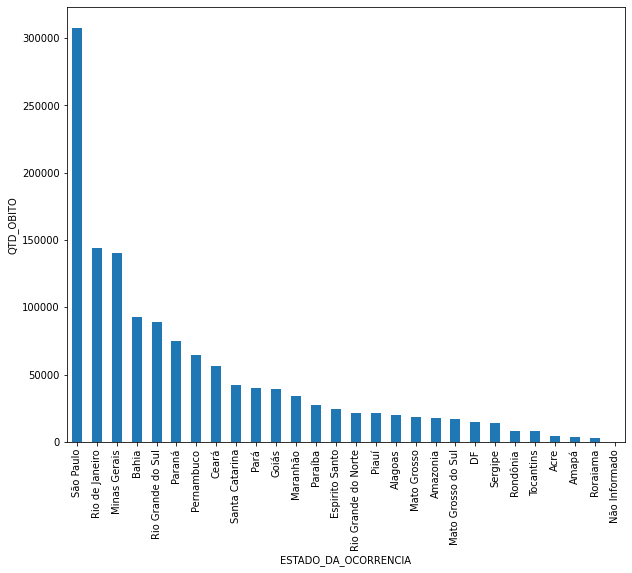

In [98]:
df_pandas.groupby(['ESTADO_DA_OCORRENCIA']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'ESTADO_DA_OCORRENCIA', ylabel= 'QTD_OBITO')

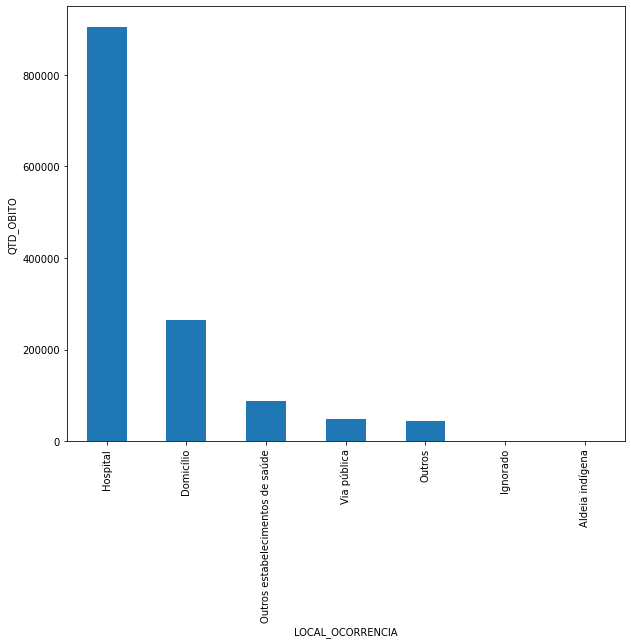

In [99]:
df_pandas.groupby(['LOCAL_OCORRENCIA']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'LOCAL_OCORRENCIA', ylabel= 'QTD_OBITO')

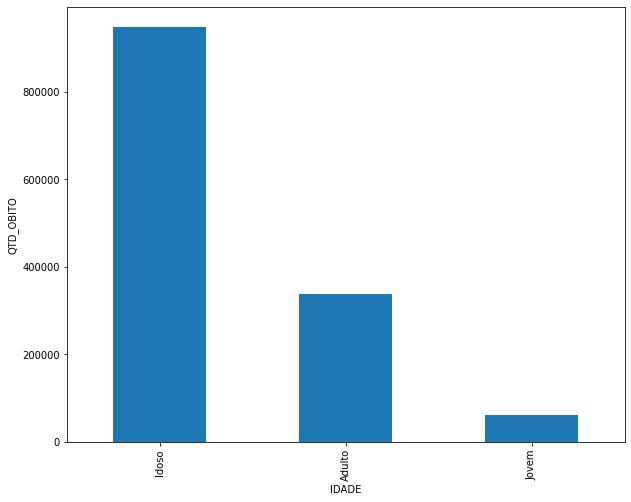

In [100]:
df_pandas.groupby(['IDADE']).size().sort_values(ascending=False).plot.bar(figsize=(10,8),xlabel = 'IDADE', ylabel= 'QTD_OBITO')

##**CONVERTENDO DATAFRAME EM CSV E ENVIANDO PARA O BUCKET**

In [101]:
#df_pandas.to_csv('gs://projeto-final/tratados/df_2019.csv', index=False)